In [2]:
from matplotlib import patches
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt

In [3]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]

![Screen Shot 2023-08-25 at 10.26.19 AM.png](<attachment:Screen Shot 2023-08-25 at 10.26.19 AM.png>)
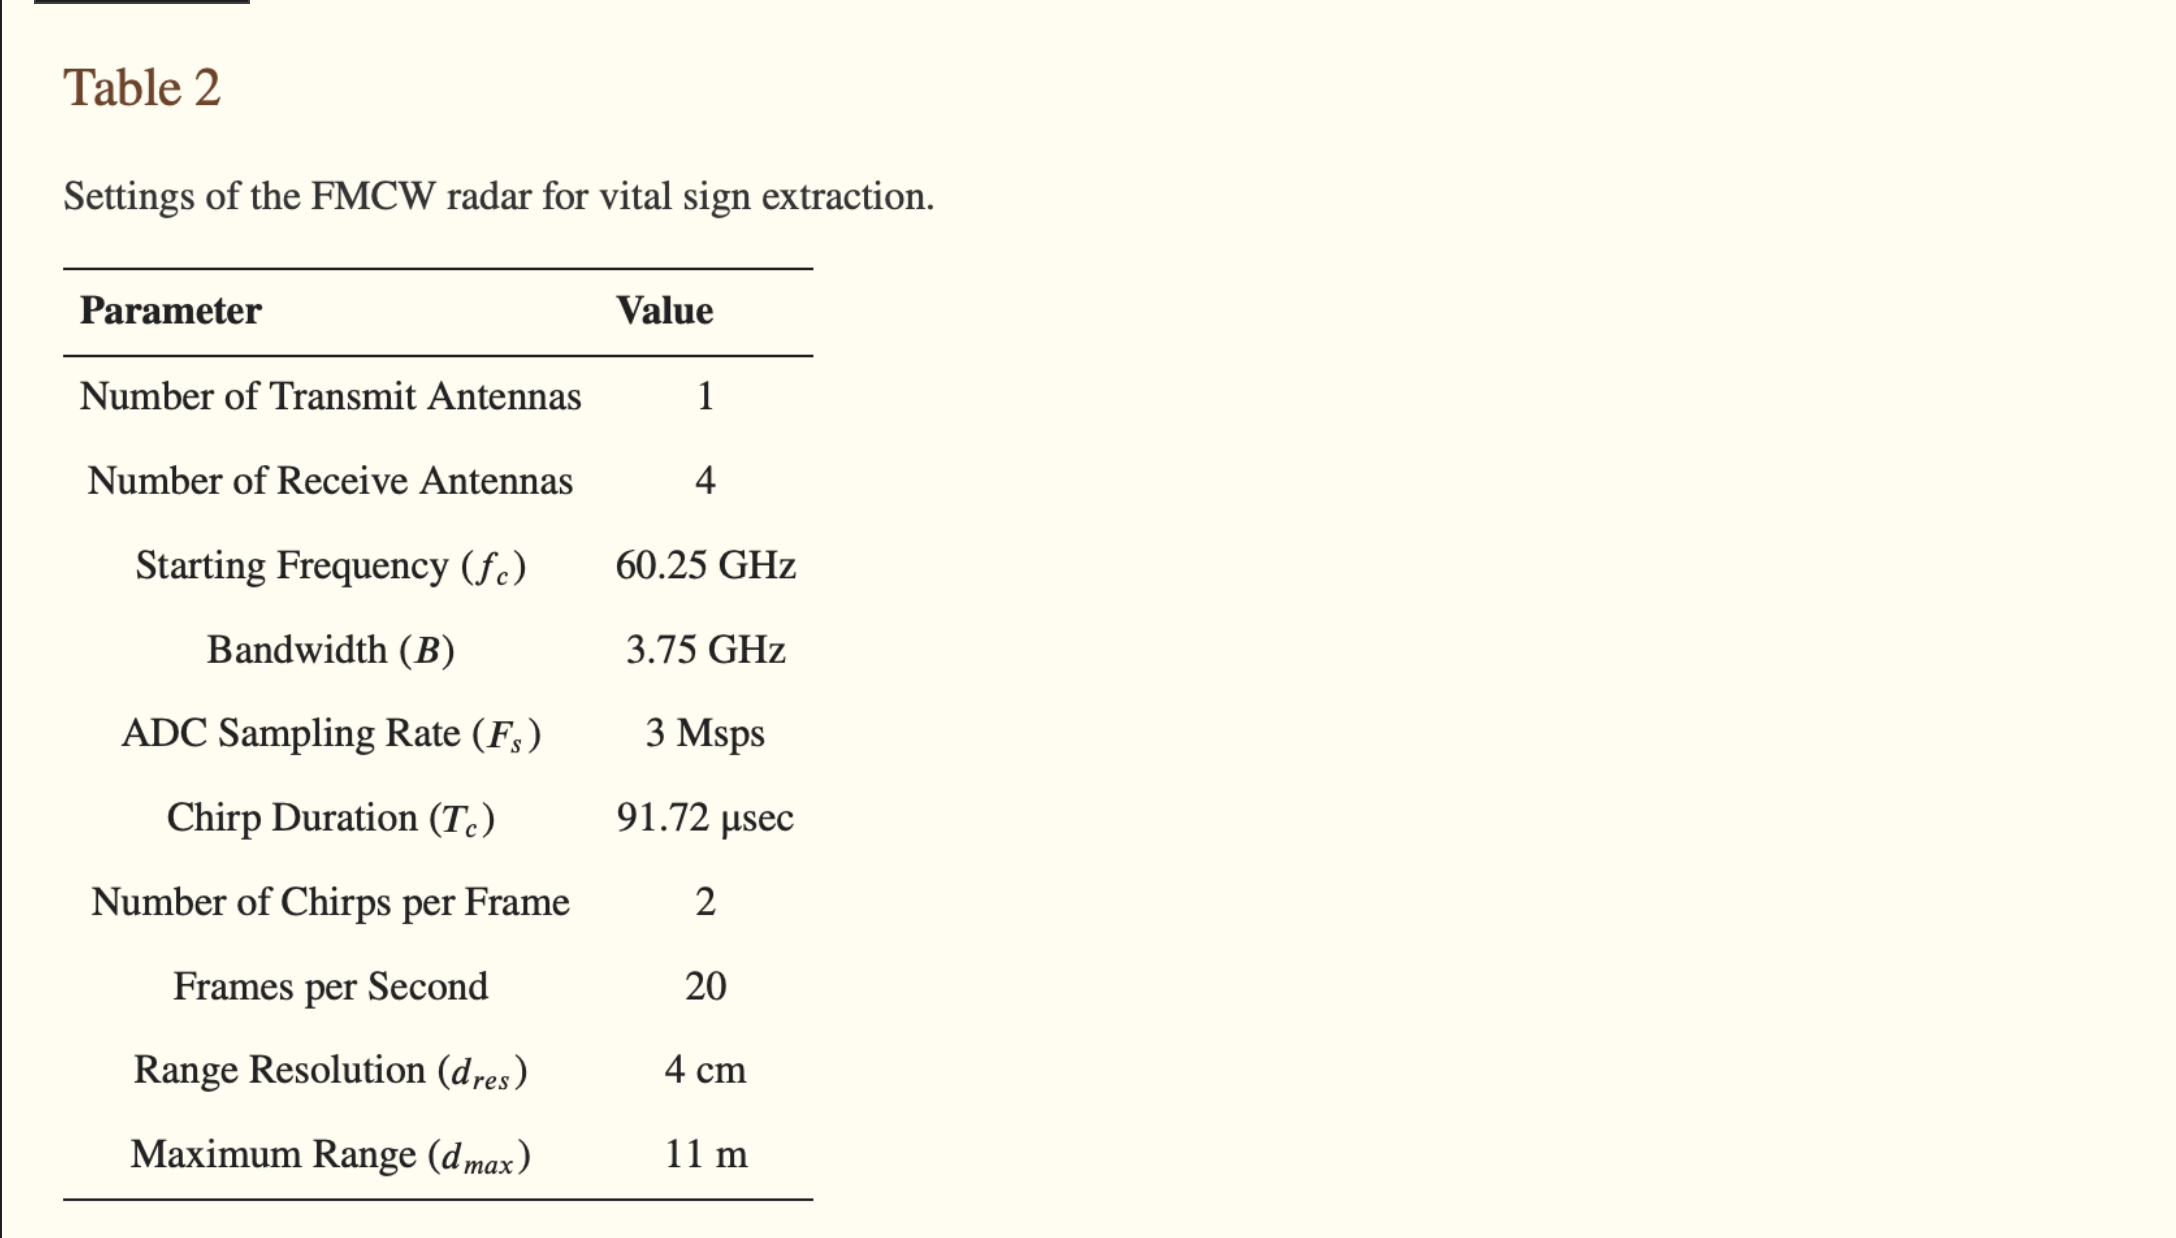

In [134]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [135]:
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP]
          for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP)]

first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)

(12000, 256)


In [136]:
fft_chirps = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitude_spectrums = [np.abs(fft_chirp) for fft_chirp in fft_chirps]

In [4]:
%matplotlib inline
x= np.arange(0,11,11/len(magnitude_spectrums[0]))
plt.plot(x,magnitude_spectrums[0])
plt.plot(x,magnitude_spectrums[2010])

plt.xlabel('meters')
plt.ylabel('Amplitude')
plt.show()

NameError: name 'np' is not defined

In [ ]:

#find it's manitude
magnitude_index = np.zeros(shape=len(magnitude_spectrums))
for  magnitude_spectrum in magnitude_spectrums:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[1:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]
bin_of_interest=20
for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)


index: 1  :  20.0
index: 6  :  74.0
index: 7  :  330.0
index: 8  :  5453.0
index: 9  :  1667.0
index: 10  :  1060.0
index: 11  :  369.0
index: 12  :  107.0
index: 13  :  8.0
index: 19  :  2911.0
index: 31  :  1.0


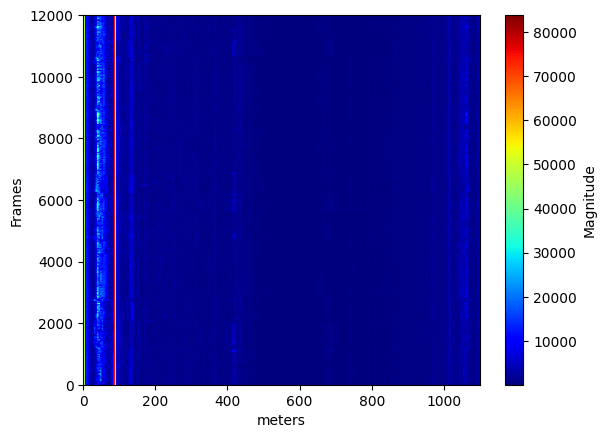

In [ ]:
tmp_array = np.zeros(shape=np.array(magnitude_spectrums).shape)
tmp_array= copy.deepcopy(magnitude_spectrums)
for tmp in tmp_array:
    tmp[bin_of_interest]=80000

plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[0,MAX_RANGE,0,len(fft_chirps)])
# Add labels and colorbar
plt.xlabel('meters')
plt.ylabel('Frames')
# plt.title('Averaged Magnitude Range-Doppler Heatmap')
plt.colorbar(label='Magnitude')

# Show the plot
plt.show()


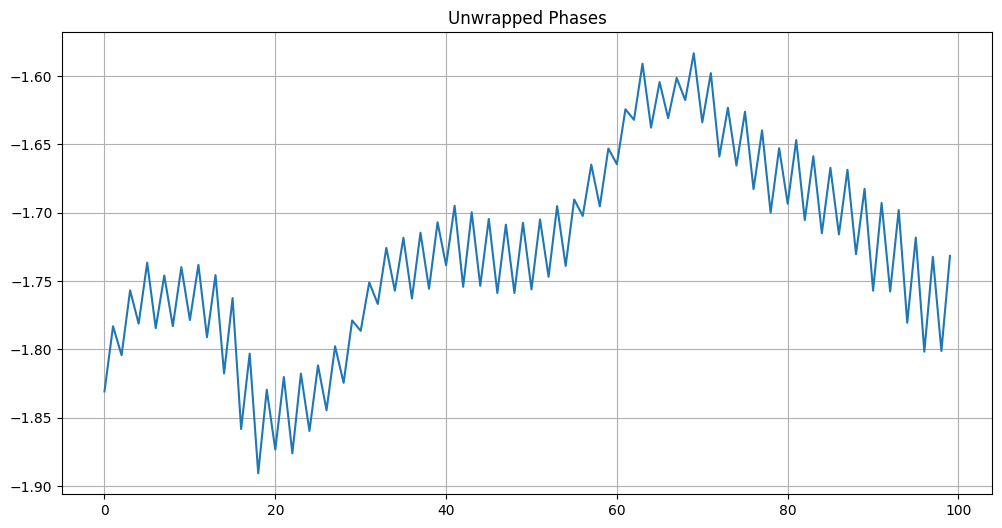

In [ ]:
ffts_interested_bin = [fft_chirp[bin_of_interest] for fft_chirp in fft_chirps]
angles = np.angle(np.array(ffts_interested_bin).flatten())
unwrapped_phase = np.unwrap(angles)
chirp_length = 256
# frequency_slope = B / T_c

# fft_result = np.fft.fft(unwrapped_phase)
# frequency_resolution = SAMPLING_RATE / len(fft_result)  # Frequency 
# frequencies = np.fft.fftfreq(len(fft_result), d=1/SAMPLING_RATE) 

# peaks, _ = find_peaks(np.abs(fft_result))

# peak_indices = peaks * chirp_length  # Convert peak indices to sample indices
# peak_frequencies = frequency_slope * peak_indices / sampling_rate  # Calculate the frequency corresponding to each peak



# Filter out low-amplitude peaks
# amplitudes = np.abs(fft_result[peaks])
# threshold = amplitudes.mean()  # Adjust the threshold as needed
# peaks = peaks[amplitudes > threshold]
# peak_frequencies = frequencies[peaks]


plt.figure(figsize=(12, 6))

# plt.plot(peak_frequencies, unwrapped_phase[peaks], 'ro', label='Peaks')
# for i, peak in enumerate(peaks):
#     plt.annotate(peak_frequencies[i], (peak_frequencies[i], unwrapped_phase[peak]), textcoords="offset points", xytext=(0,10), ha='center')
# plt.plot(frequencies, np.abs(fft_result))
# plt.plot(peak_frequencies, np.abs(fft_result[peaks]), 'ro')

plt.plot(unwrapped_phase)
plt.title('Unwrapped Phases')
plt.grid(True)
plt.show()


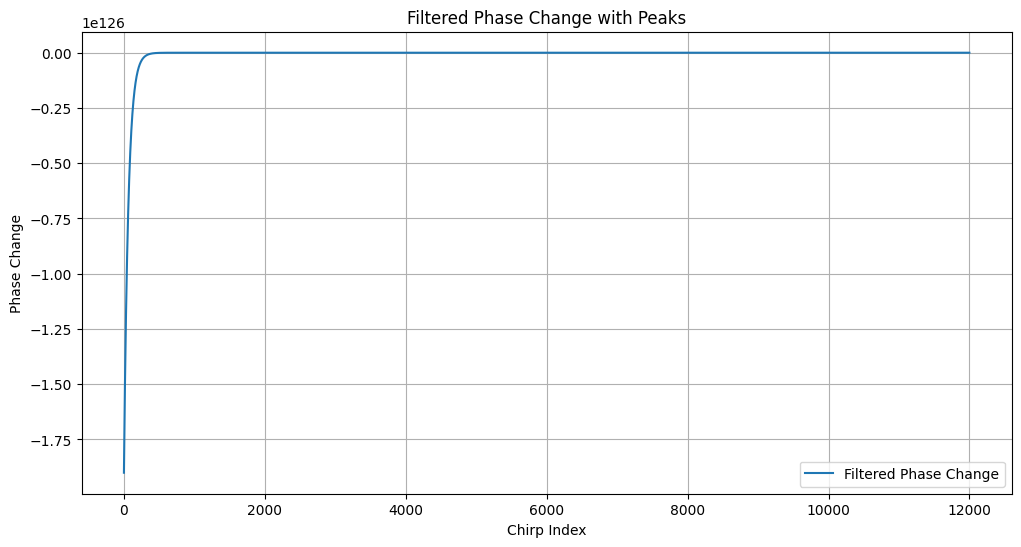

In [ ]:
fs = 1/T_c  # Sampling frequency (assuming each chirp has a duration of 1 unit)
lowcut = 0.4  # Lower cutoff frequency of the bandpass filter
highcut = 5.0  # Upper cutoff frequency of the bandpass filter
order = 4  # Filter order

# Normalize the cutoff frequencies
nyquist_freq = 0.5 * fs
low = lowcut / nyquist_freq
high = highcut / nyquist_freq

# Apply the bandpass filter
b, a = butter(order, [low, high], btype='band', fs=fs)
filtered_phase_change = filtfilt(b, a, unwrapped_phase)
peaks, _ = find_peaks(filtered_phase_change)

plt.figure(figsize=(12, 6))
# plt.plot(unwrapped_phase, label='Phase Change')
plt.plot(filtered_phase_change, label='Filtered Phase Change')
# plt.plot(peaks, filtered_phase_change[peaks], 'ro', label='Peaks')
plt.xlabel('Chirp Index')
plt.ylabel('Phase Change')
plt.title('Filtered Phase Change with Peaks')
plt.legend()
plt.grid(True)
plt.show()
